# Computational Cognitive Neuroscience Practical Assignment 3
## Training an RNN on sequential random data
### Tommy Clausner (s4836219) and Steven Smits (s4237263)

In [11]:
import numpy as np
import chainer
from chainer import optimizers
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import matplotlib.pyplot as plt
from chainer.iterators import SerialIterator as SerIt

## Function provided by assigment is defined

In [12]:
def create_data(n=3000):

    X = np.random.rand(n,1).astype('float32')
    T = np.sum(np.hstack((X[0:-1],X[1:])),axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n,1])

    return TupleDataset(X, T)

### Functions that are provided, but modifed for our RNN
We create a RNN having one LSTM layer and one linear output layer according to the chainer documentation.
For evaluating the model we use a Regressor that evaluates the L2-norm between the predicted and the actual value. The loss is accumulated over "time points" of the input data.

In [13]:
class RNN(chainer.Chain):
        def __init__(self,nunits):
            super(RNN, self).__init__()
            with self.init_scope():
                self.mid = L.LSTM(1, nunits)  # the first LSTM layer.. Input single number, so RNN has to remember previous ones.
                self.out = L.Linear(nunits, 1)  # the feed-forward output layer

        def reset_state(self):
            self.mid.reset_state()

        def __call__(self, x): #changed cur_word to x
            h = self.mid(x)
            y = self.out(h)
            return y
        
class MyRegressor(chainer.Chain):
    """This function returns the cumulative loss of the current batch. Batchsizes can be any > 0 value."""
    def __init__(self, predictor):
        super(MyRegressor, self).__init__(predictor=predictor)
        self.loss =None
        self.pred = None

    def __call__(self, input, target):
        # This chain just computes the mean absolute and squared
        # errors between the prediction and y.

        if len(input) > 1: # If more than 1 element, compute cumulative batch loss
            loss = 0
            for i in range(len(input)):
                x = chainer.Variable(np.asarray([input._data[0][i].tolist()], dtype='float32'))  # Work around such that model accepts single input [[x]].
                t = chainer.Variable(np.asarray([target._data[0][i].tolist()], dtype='float32'))
                self.pred = self.predictor(x)
                loss += F.mean_squared_error(self.pred, t)
            # loss += model(x, t)

            self.loss = loss
        else: # If input is one element, compute element loss
            x = chainer.Variable(np.asarray([input.data.tolist()], dtype='float32'))
            t = chainer.Variable(np.asarray([target.data.tolist()], dtype='float32'))

            self.pred = self.predictor(x)
            self.loss = F.mean_squared_error(self.pred, t)

        return self.loss

### Self made functions (part 2 of assignment)
The final predictions are obtained using the function below and later compared to the real values.

In [14]:
def get_sum(n,rnn,model):
    """Returns the predicted and real sum per time step in an array. """
    rnn.reset_state() # Reset state to be sure we're not working with previous input.
    predicts = np.zeros(n) # Storage array for predicted values.
    reals = np.zeros(n) # Storage arrat for actual target values.
    sumdata= create_data(n=n) # Creating the test data for this, it is already random.

    for i in range(n):
        predicts[i] = model.predictor(chainer.Variable(np.asarray([sumdata._datasets[0][i].tolist()], dtype='float32'))).data # Each element is its own prediction + the previous element[which is the summ over all previous..]
        reals[i] = sumdata._datasets[1][i] # Same as predicts, but easier as the targets are readily available in a nice format.
    return [reals, predicts]

## The RNN
The main function for the recurrent neural network (RNN) is executed in the cell below. For each batch the model is updated according to the cummulated loss. This contrasts the discription of 'per epoche', however this method is faster with comparable results. In our case it further arguable that only two datapoints are informative in the first place and hence it is not necessary to store the previous (N > 2) computations of the whole dataset.

Please note:
The "Accuracy" is computed as follows: Since we add two random numbers (0 <= R <= 1) the maximum sum we obtain is 2. Hence the maximum difference between prediction and actual value is also 2 (because of the sum of the two previous timepoints). If we now use the difference between prediction and actual value and devide it by two, we rescale it to 1. If we further subtract it to 1 we obtain the realtive offset of our prediction in terms of "accuracy".

epoch  1
Train loss:  108.361418784
Test loss:  46.6533886194
epoch  2
Train loss:  41.7969267964
Test loss:  39.049040705
epoch  3
Train loss:  35.5634043515
Test loss:  35.6193777621
epoch  4
Train loss:  33.0459410399
Test loss:  32.0055820644
epoch  5
Train loss:  31.0504695177
Test loss:  28.7972844243
epoch  6
Train loss:  29.2898774892
Test loss:  26.0960827768
epoch  7
Train loss:  27.6716107577
Test loss:  23.8907659352
epoch  8
Train loss:  26.1444756091
Test loss:  21.9348674715
epoch  9
Train loss:  24.654671669
Test loss:  20.0297463089
epoch  10
Train loss:  23.1511527598
Test loss:  18.0884757787
epoch  11
Train loss:  21.6000038385
Test loss:  16.0933498293
epoch  12
Train loss:  19.9949869365
Test loss:  14.0678800642
epoch  13
Train loss:  18.3588160425
Test loss:  12.0663404241
epoch  14
Train loss:  16.736571759
Test loss:  10.1618615165
epoch  15
Train loss:  15.183475323
Test loss:  8.42708341777
epoch  16
Train loss:  13.7500019968
Test loss:  6.91700377688
epoch

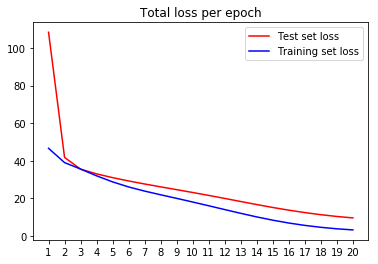

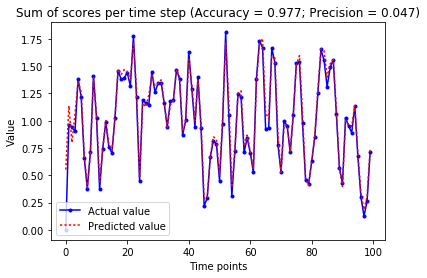

In [15]:
def DoRNN():
    # Setting up stable factors to be used
    batchsize = 20  # Batchsize for training and testing
    epochs = 20  # Number of training and testing epochs
    n_epoch = epochs  # To be usedfor the loop
    n = 1000  # Standard by lecturer is 3000, but with lower n the training becomes more clear. With n=3000, the model needs only few epochs to converge.
    nunits=10 # number of neurons in the network
    rnn = RNN(nunits)  # Our neural network model
    model = MyRegressor(rnn)  # Regressor that calculates the cumulated loss per batch


    # Setting up optimizer
    optimizer = optimizers.SGD()  # Using good old stchastic gradient descent
    optimizer.setup(model)

    traindata = create_data(n=n)  # Initializing training data
    testdata = create_data(n=n)  # Initializing test data

    train_loss = np.zeros(epochs)  # Storage array for training loss
    test_loss = np.zeros(epochs)  # Storage array for testing loss

    for epoch in range(1, n_epoch + 1):  # start with epoch 1 (instead of 0)
        print('epoch ', epoch)
        # rnn.reset_state() #If it's here its slow, if it's in iteration its fast, but almost same results.. Use this with low n=..

        # Training loop
        train_data = SerIt(traindata, batch_size=batchsize, repeat=False,
                           shuffle=False)  # Create Random training batch iterations.
        for batch in train_data:  # For every batch
            input, target = zip(*batch)  # Distinguish input and target from current batch.
            input = chainer.Variable(np.asarray(input))  # Input to chainer.Variable.
            target = chainer.Variable(np.asarray(target))  # Target to chainer.Variable.

            rnn.reset_state()  # Have to do this everytime after using optimizer.update() according to chainer documentation. In contrast, the assignment says per epoch. The former is more logical.
            optimizer.update(model, input, target)  # Update model. Accumulated loss is in the Regressor model.
            train_loss[epoch - 1] += model.loss.data  # Store cumulative batch loss

        print("Train loss: ", train_loss[epoch - 1])

        # Test loop
        test_data = SerIt(testdata, batch_size=batchsize, repeat=False,
                          shuffle=False)  # Create Random test batch iterations.
        for batch in test_data:  # For every batch
            input, target = zip(*batch)  # Distinguish input and target from current batch.
            input = chainer.Variable(np.asarray(input))  # Input to chainer.Variable.
            target = chainer.Variable(np.asarray(target))  # Target to chainer.Variable.

            test_loss[epoch - 1] += model(input, target).data  # Store cumulative batch loss

        print("Test loss: ", test_loss[epoch - 1])


    # Plot Training and test loss
    plt.plot(range(1, epochs + 1), train_loss, 'r', range(1, epochs + 1), test_loss, 'b');
    plt.legend(['Test set loss', 'Training set loss']);
    plt.title('Total loss per epoch');
    plt.xticks(range(1, n_epoch + 1));
    plt.show()
    
    # Part 2 of assignment: Plot predicted sum and actual sum per time.
    sums = get_sum(100, rnn,model)  # Computes two arrays with every element being the sum of its previous elements and itself.
    plt.figure();
    plt.plot(range(0,len(sums[0])), sums[0],'b.-',range(0,len(sums[0])),sums[1], 'r:');
    plt.legend(['Actual value','Predicted value']);
    plt.ylabel('Value');
    plt.xlabel('Time points');
    acc=round(1-sum(abs(sums[0]-sums[1]))/100/2.,3)
    prec=round(sum(abs(sums[0]-sums[1]))/100.,3)
    plt.title('Sum of scores per time step (Accuracy = '+str(acc)+'; Precision = '+str(prec)+')');
    plt.show()
DoRNN()

### NOT GRADED (seriousely!): We made our own serializers and used Adaptive GD, which works supriselingly well. We were curious why and thought it might interest you.

A summary of what we changed:
- we use new data for each training epoch
- we input the whole batch to the LSTM at once (major source for/of our curiousity)
- we use our own sequentializer
- we use Adaptive Gradient (AdaGrad) with a learning rate that adapts to the number of neurons in the LSTM (major source for/of our curiousity)

Whats so surprising:
- it's incredibly fast at a higher accuracy (even when the old data is used for the different epochs)
- please run the code (as already said, it's fast ;) ) and look at the results: why are they so good?

Yes, it might sound a bit strange, but we were really curious about how this could be and we so far couldn't find a satisfactory explanation. So if you wouldn't mind we would be really happy to read a small comment on this as well ;)

Thanks a lot!

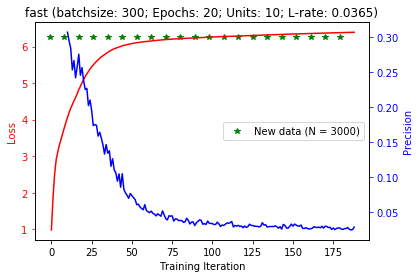

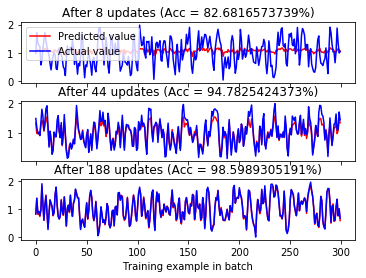

Summary: fast
Final Precision: 0.0280213896185
Final MSE: 0.000785198276153
Final Accuracy: 98.5989305191%
Total number of epochs: 20
Datasets per epoche: 3000
Iterations per epoch: 10
Total number of iterations: 191
Batch size per iteration: 300
Learning rate: 0.0365109119636
time for training in s: 0.887747049332


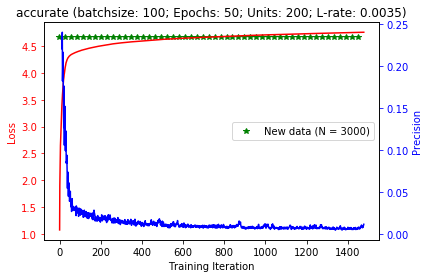

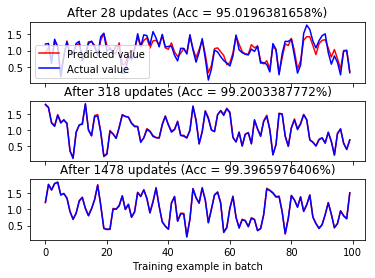

Summary: accurate
Final Precision: 0.0120680471882
Final MSE: 0.000145637762937
Final Accuracy: 99.3965976406%
Total number of epochs: 50
Datasets per epoche: 3000
Iterations per epoch: 30
Total number of iterations: 1481
Batch size per iteration: 100
Learning rate: 0.00352873694315
time for training in s: 6.51731705666


In [16]:
from __future__ import print_function
import numpy as np
import chainer
from chainer import link
from chainer import optimizers
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import matplotlib.pyplot as plt
import time

# create toy data - compute sum of the previous and current input
def create_data(n):

    X = np.random.rand(n,1).astype('float32')
    T = np.sum(np.hstack((X[0:-1],X[1:])),axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n,1])

    return TupleDataset(X, T)

# sequencer for the model
def RNNsequencer(data,model,optimizer,batchsize,epochs,newdata=1):
    epochs+=1 # for the later range command
    count = -1 # initialize iteration counter
    seqlen = len(data._datasets[0]) # n

    loss_plot = np.zeros((len(data._datasets[0])//batchsize*epochs - epochs, 1)) # initialize list for plotting loss
    err_plot = np.zeros((len(data._datasets[0])//batchsize*epochs - epochs, 1)) # initialize list for plotting error
    newdatacount=np.zeros((epochs,1)) # initialize list for plotting new data onset
    newdatacount[0]=1
    loss = 0 # initialize loss
    for j in range(0,epochs):
        #print(str(round(count / float(epochs) / seqlen * batchsize * 100, 1)) + " percent complete \r")
        if newdata: # create new data for each epoch
            data = create_data(seqlen)
            newdatacount[j]=count

        for i in range(1,seqlen-batchsize,batchsize): # loop over data in chunks of batchsize
            count = count + 1
            loss_new,abs_error,pred = model(F.concat((data._datasets[0][i-1:i+batchsize-1],data._datasets[0][i:i+batchsize]),1),data._datasets[1][i:i+batchsize])
            loss=loss+loss_new # cumulative loss (MSE)
            loss_plot[count]=loss.data
            err_plot[count] = abs_error.data # error

            # for plots of 3 different training stages (after 1st, epochs//5th and last epoche)
            if j==0:
                pred_plot_first = pred.data
                resplot_first = data._datasets[1][i:i + batchsize]
                countfirst = count
                errfirst = err_plot[count]
            if j == epochs//5 or j==0:
                pred_plot_mid = pred.data
                resplot_mid = data._datasets[1][i:i + batchsize]
                countmid=count
                errmid=err_plot[count]
            if j == epochs - 1 or j==0:
                pred_plot = pred.data
                resplot = data._datasets[1][i:i + batchsize]
                countlast = count
                errlast = err_plot[count]
            # update model
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    #print(str(round(count / float(epochs) / seqlen * batchsize * 100, 1)) + " percent complete \r")
    return newdatacount,loss_plot,err_plot,pred_plot_first,resplot_first, countfirst, errfirst,pred_plot_mid,resplot_mid,countmid,errmid,pred_plot,resplot,countlast,errlast

# plot results
def plotRNNresults(newdatacount,loss_plot,err_plot,
                   pred_plot_first,resplot_first,
                   countfirst, errfirst,pred_plot_mid,
                   resplot_mid,countmid,errmid,pred_plot,
                   resplot,countlast,errlast,n,batchsize,setting):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(newdatacount, np.ones((np.size(newdatacount), 1)) * np.median(loss_plot), '*g', )
    ax1.legend(['New data (N = ' + str(n) + ')'], loc=7)
    ax1.plot(loss_plot, 'red')
    ax1.set_xlabel('Training Iteration')
    ax1.set_ylabel('Loss', color='red')
    ax1.tick_params(axis='y', colors='red')
    ax2.plot(range(10, len(err_plot)), err_plot[10:], 'blue')
    ax2.set_ylabel('Precision', color='blue')
    ax2.tick_params(axis='y', colors='blue')
    ax1.set_title(setting+' (batchsize: ' + str(batchsize) + '; Epochs: '+str(epochs)+'; Units: '+str(nunits)+'; L-rate: '+str(round(lrate,4))+')')

    fig, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(pred_plot_first, 'red', resplot_first, 'blue')
    axarr[0].set_title('After ' + str(countfirst) + ' updates (Acc = ' + str((1 - (errfirst[0]) / 2) * 100) + '%)')
    axarr[1].plot(pred_plot_mid, 'red', resplot_mid, 'blue')
    axarr[1].set_title('After ' + str(countmid) + ' updates (Acc = ' + str((1 - (errmid[0]) / 2) * 100) + '%)')
    axarr[2].plot(pred_plot, 'red', resplot, 'blue')
    axarr[2].set_title('After ' + str(countlast) + ' updates (Acc = ' + str((1 - (errlast[0]) / 2) * 100) + '%)')
    axarr[0].legend(['Predicted value', 'Actual value'])
    axarr[2].set_xlabel('Training example in batch')
    fig.subplots_adjust(hspace=0.3)
    plt.show()

# Does RNN computation according to initial settings
def DoRNN(n,batchsize,epochs,nunits,lrate,setting):
    a = time.time() # reference time measure for training
    data=create_data(n) # create data
    rnn = RNN(nunits) # setup RNN
    model = MSE(rnn) # setup model
    optimizer = optimizers.AdaGrad(lr=lrate)    # Adaptive Gradient (AdaGrad) works much better
                                                # than stochastic gradient decent (SGD)
    #optimizer = optimizers.SGD()
    optimizer.setup(model)
    rnn.reset_state()

    newdatacount,loss_plot,err_plot,pred_plot_first,\
    resplot_first, countfirst, errfirst,\
    pred_plot_mid,resplot_mid,countmid,\
    errmid,pred_plot,resplot,countlast,errlast= \
        RNNsequencer(data,model,optimizer,batchsize,epochs) # run sequencer

    plotRNNresults(newdatacount,loss_plot,err_plot,pred_plot_first,
                   resplot_first, countfirst, errfirst,
                   pred_plot_mid,resplot_mid,countmid,
                   errmid,pred_plot,resplot,countlast,errlast,n,batchsize,setting) # plot results
    b = time.time() # reference time measure for training

    # print summary after the current computation
    print('\rSummary: '+setting)
    print('Final Precision: '+str(err_plot[-1][0]))
    print('Final MSE: ' + str(err_plot[-1][0]**2))
    print('Final Accuracy: '+str((1-(err_plot[-1][0])/2)*100)+'%')
    print('Total number of epochs: ' + str(epochs))
    print('Datasets per epoche: ' + str(n))
    print('Iterations per epoch: ' + str(n//batchsize))
    print('Total number of iterations: ' + str(countlast +3))
    print('Batch size per iteration: ' + str(batchsize))
    print('Learning rate: ' + str(lrate))
    print('time for training in s: ' + str(b - a))

# Choose initial settings (network architecture, number os epochs, etc.)
def choose_setting(setting,lrate_init=0.22):
    if setting=='accurate':
        batchsize=100
        epochs=50
        nunits=200
    elif setting == 'accurate single':
        batchsize = 100
        epochs = 50
        nunits = 1
    elif setting == 'stunning but long':
        batchsize = 10
        epochs = 200
        nunits = 200
    elif setting == 'fast single':
        batchsize = 300
        epochs = 20
        nunits = 1
    elif setting == 'fast':
        batchsize = 300
        epochs = 20
        nunits = 10
    else:
        print("no valid setting - assumed 'fast'")
        batchsize = 300
        epochs = 20
        nunits = 10
    lrate = lrate_init / (nunits ** (1-lrate_init))
    return batchsize,epochs,nunits,lrate,setting

# create LSTM recurrent neural net
class RNN(chainer.Chain):
    def __init__(self,x):
        super(RNN, self).__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, x) # LSTM layer
            self.l2 = L.Linear(x, 1) # linear layer

    def reset_state(self):
        self.l1.reset_state()

    def __call__(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

# create evaluator (mean square error (MSE))
class MSE(chainer.Chain):
    def __init__(self, predictor):
        super(MSE, self).__init__(predictor=predictor)

    def __call__(self, x, y):
        # This chain just computes the mean absolute and squared
        # errors between the predicted value and y (actual value).
        pred = self.predictor(x)
        abs_error = F.sum(F.absolute(pred - y)) / len(x.data)
        loss = F.mean_squared_error(pred, y)

        # Report the mean absolute and squared errors.
        chainer.report({'abs_error': abs_error, 'squared_error': loss}, self)

        return loss,abs_error,pred


n=3000 # number of examples per epoche
IncludeStunningButLongResult=0 # set to 1 only if your patience allows

# fast training
batchsize,epochs,nunits,lrate,setting=choose_setting('fast')
DoRNN(n,batchsize,epochs,nunits,lrate,setting)

# more accurate training
batchsize,epochs,nunits,lrate,setting=choose_setting('accurate')
DoRNN(n,batchsize,epochs,nunits,lrate,setting)

# very accurate training
if IncludeStunningButLongResult:
    batchsize,epochs,nunits,lrate,setting=choose_setting('stunning but long')
    DoRNN(n,batchsize,epochs,nunits,lrate,setting)